In [23]:
# pip install --no-binary :all: pmdarima

In [5]:
import sys
print(sys.executable)
print(sys.version)

/usr/local/bin/python3
3.12.5 (v3.12.5:ff3bc82f7c9, Aug  7 2024, 05:32:06) [Clang 13.0.0 (clang-1300.0.29.30)]


In [1]:
import pandas as pd
print(pd.__version__)

import numpy as np
print(np.__version__)

import statsmodels
print(statsmodels.__version__)

import matplotlib
print(matplotlib.__version__)
import matplotlib.pyplot as plt

import seaborn as sns
print(sns.__version__)

2.2.3
2.1.2
0.14.4
3.9.2
0.13.2


Data Import

In [7]:
#Load the data
VIX_data = pd.read_csv('VIX_data.csv')

In [8]:
print(VIX_data.head())
print(VIX_data.shape)
print(VIX_data.index)

         Date  Unemployment Rate      CPI  Three Month T Bill Rate  \
0  2014-09-01                5.9  237.477                     0.02   
1  2014-10-01                5.7  237.430                     0.02   
2  2014-11-01                5.8  236.983                     0.02   
3  2014-12-01                5.6  236.252                     0.03   
4  2015-01-01                5.7  234.747                     0.03   

   Six Month T Bill Rate  10-Year Treasury Constant Maturity Rate  Fed Rate  \
0                   0.04                                     2.53      0.09   
1                   0.05                                     2.30      0.09   
2                   0.07                                     2.33      0.09   
3                   0.11                                     2.21      0.12   
4                   0.08                                     1.88      0.11   

   BBB Rate  SP500 Index   VIX_x  ...  USD INDEX Open  USD INDEX High  \
0      3.54     1975.045  12.88

In [9]:
fred_data = pd.read_csv('VIX_FRED_data.csv')

In [10]:
print(fred_data.head())
print(fred_data.shape)

         Date  Unemployment Rate      CPI  Three Month T Bill Rate  \
0  2014-09-01                5.9  237.477                     0.02   
1  2014-10-01                5.7  237.430                     0.02   
2  2014-11-01                5.8  236.983                     0.02   
3  2014-12-01                5.6  236.252                     0.03   
4  2015-01-01                5.7  234.747                     0.03   

   Six Month T Bill Rate  10-Year Treasury Constant Maturity Rate  Fed Rate  \
0                   0.04                                     2.53      0.09   
1                   0.05                                     2.30      0.09   
2                   0.07                                     2.33      0.09   
3                   0.11                                     2.21      0.12   
4                   0.08                                     1.88      0.11   

   BBB Rate  SP500 Index     VIX        GDP  Initial Claims  \
0      3.54     1975.045  12.880  17804.2

In [11]:
yf_data = pd.read_csv('VIX_YF_data.csv')

In [12]:
print(yf_data.head())
print(yf_data.shape)

         Date  SP500 Volume  NASDAQ Open  NASDAQ High   NASDAQ Low  \
0  2014-09-01   66706000000  4592.419922  4610.569824  4464.439941   
1  2014-10-01   93714040000  4486.649902  4641.509766  4116.600098   
2  2014-11-01   63600190000  4633.709961  4810.859863  4594.919922   
3  2014-12-01   80743820000  4777.729980  4814.950195  4547.310059   
4  2015-01-01   77330040000  4760.240234  4777.009766  4563.109863   

   NASDAQ Close  NASDAQ Adj Close  NASDAQ Volume      DJI Open      DJI High  \
0   4493.390137       4493.390137    39631130000  17097.419922  17350.640625   
1   4630.740234       4630.740234    50136190000  17040.460938  17395.539062   
2   4791.629883       4791.629883    32967990000  17390.900391  17894.830078   
3   4736.049805       4736.049805    39587090000  17827.269531  18103.449219   
4   4635.240234       4635.240234    38719030000  17823.070312  17951.779297   

   ...  USD INDEX High  USD INDEX Low  USD INDEX Close  USD INDEX Adj Close  \
0  ...       86.220

Data Cleaning

In [13]:
#Set Date as index
VIX_data['Date'] = pd.to_datetime(VIX_data['Date'])
VIX_data.set_index('Date', inplace=True)

#Sort the data by Date
VIX_data.sort_index(inplace=True)

In [14]:
#Handle missing data 
def handle_missing_data(data):
    missing_values = data.isnull().sum()
    print('Missing values before handling:\n',missing_values)

    #Make a copy to avoid modifying the original data
    data_filled = data.copy()

    #Fill missing values with the mean of each column
    data_filled = data.fillna(data.mean())

    #Print missing values after handling
    missing_values_after = data_filled.isnull().sum()
    print('Missing values after handling:\n', missing_values_after)

    return data_filled

In [18]:
data = handle_missing_data(VIX_data)

print("\n First few rows of processed data:")
print(data.head())

Missing values before handling:
 Unemployment Rate                          0
CPI                                        0
Three Month T Bill Rate                    0
Six Month T Bill Rate                      0
10-Year Treasury Constant Maturity Rate    0
                                          ..
VXN Open                                   0
VXN High                                   0
VXN Low                                    0
VXN Close                                  0
VXN Adj Close                              0
Length: 61, dtype: int64
Missing values after handling:
 Unemployment Rate                          0
CPI                                        0
Three Month T Bill Rate                    0
Six Month T Bill Rate                      0
10-Year Treasury Constant Maturity Rate    0
                                          ..
VXN Open                                   0
VXN High                                   0
VXN Low                                    0
VXN Close 

In [34]:
vix = data['VIX_x']

print(vix.head())

Date
2014-09-01    12.880
2014-10-01    16.530
2014-11-01    13.330
2014-12-01    15.155
2015-01-01    19.455
Name: VIX_x, dtype: float64


Stationarity Check

In [25]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [26]:
#Check Stationarity 
def check_stationarity(timeseries):
    stationarity_result = adfuller(timeseries,autolag='AIC')
    print(f'ADF Statistic: {stationarity_result[0]}')
    print(f'p-value:{stationarity_result[1]}')
    print('Critical Values:')
    for key, value in stationarity_result[4].items():
        print(f'\t{key}:{value}')

    if stationarity_result[1] <= 0.05:
        print("The series is stationary")
    else:
        print("The series is not stationary")

In [27]:
check_stationarity(data['VIX_x'])

#Check for all the features


ADF Statistic: -4.121092523312762
p-value:0.0008936280142109903
Critical Values:
	1%:-3.4954932834550623
	5%:-2.8900369024285117
	10%:-2.5819706975209726
The series is stationary


Plot Time Series Data

In [53]:
#Plot Time Series data
def plot_series(data, title):
    plt.figure(figsize=(10,6))
    plt.plot(data)
    plt.title(title)
    plt.show()

Determine ARIMA order p,d,q
- p: number of lag observations (AR term)
- d: degree of differencing (I term)
- q: size of the moving average window (MA term)

Determine the order of differencing (d)

In [30]:
#Determine d
def determine_d(data):
    d=0
    while not check_stationarity(data):
        data = data.diff().dropna()
        d += 1
        if d > 2:
            print("Warning: d > 2. Consider transforming the data.")
            break
    return d, data

Plot Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
- ACF quantifies how a value in the time series relates to its previous values
- PACF is the correlation between the series values few periods apart, while accounting for the correlations at shorter lags

In [31]:
#Plot ACF and PACF
def plot_acf_pacf(data, lags=40):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
    plot_acf(data, ax=ax1, lags=lags)
    plot_pacf(data, ax=ax2, lags=lags)
    plt.show()

Suggest p and q based on ACF and PACF

In [58]:
#Suggest p and q based on ACF and PACF
def suggest_p_q(data, lags=40):
    acf_values = acf(data, nlags=lags)
    pacf_values = pacf(data, nlags=lags)

    #Suggest p (AR order) based on PACF
    p = next((i for i, v in enumerate(pacf_values) if abs(v) < 1.96/np.sqrt(len(data))),lags)

    #Suggest q (MA order) based on ACF
    q = next((i for i, v in enumerate(acf_values) if abs(v) < 1.96/np.sqrt(len(data))), lags)

    return p-1, q-1 #Subtract 1 as lag 0 is always 1

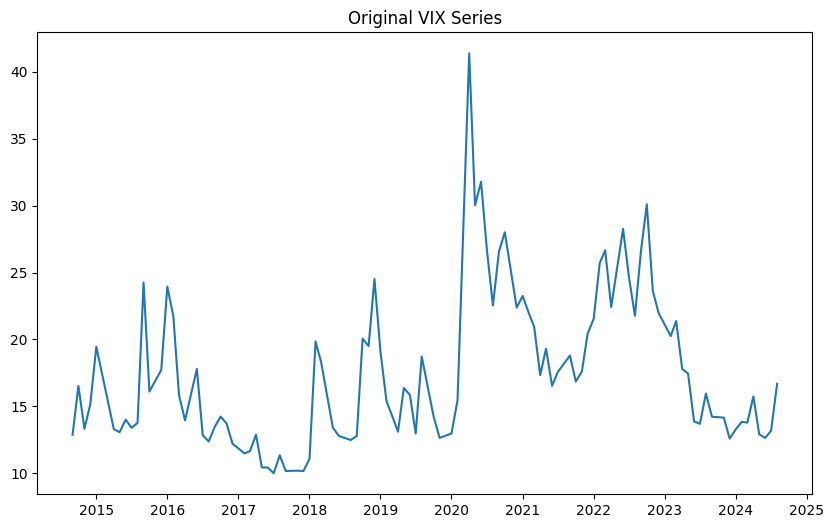

In [54]:
#Plot original data series
plot_series(vix, 'Original VIX Series')

In [36]:
#Determine d and make the series stationary 
d, stationary_vix = determine_d(vix)
print(f'Suggested d: {d}')

ADF Statistic: -4.121092523312762
p-value:0.0008936280142109903
Critical Values:
	1%:-3.4954932834550623
	5%:-2.8900369024285117
	10%:-2.5819706975209726
The series is stationary
ADF Statistic: -13.106351486040008
p-value:1.6694132208840486e-24
Critical Values:
	1%:-3.4961490537199116
	5%:-2.8903209639580556
	10%:-2.5821223452518263
The series is stationary
ADF Statistic: -7.219929354825389
p-value:2.124437135250548e-10
Critical Values:
	1%:-3.5011373281819504
	5%:-2.8924800524857854
	10%:-2.5832749307479226
The series is stationary
Suggested d: 3


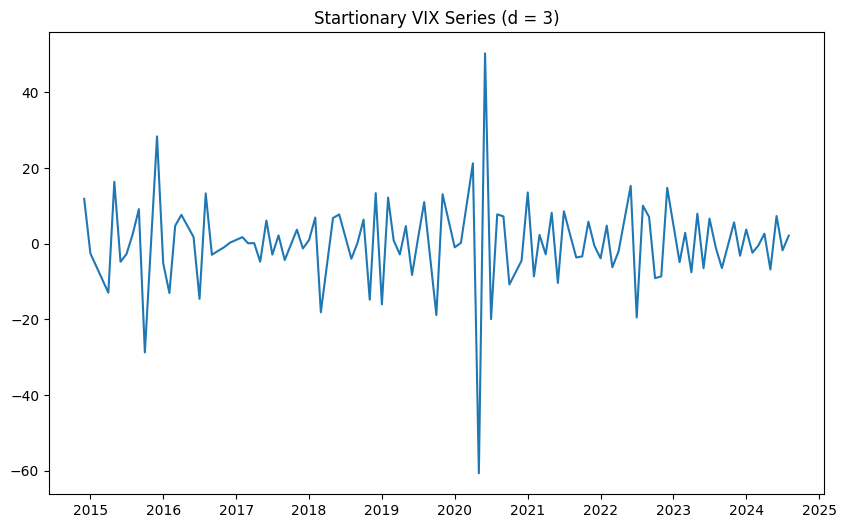

In [55]:
#Plot stationary series
plot_series(stationary_vix, f'Startionary VIX Series (d = {d})')

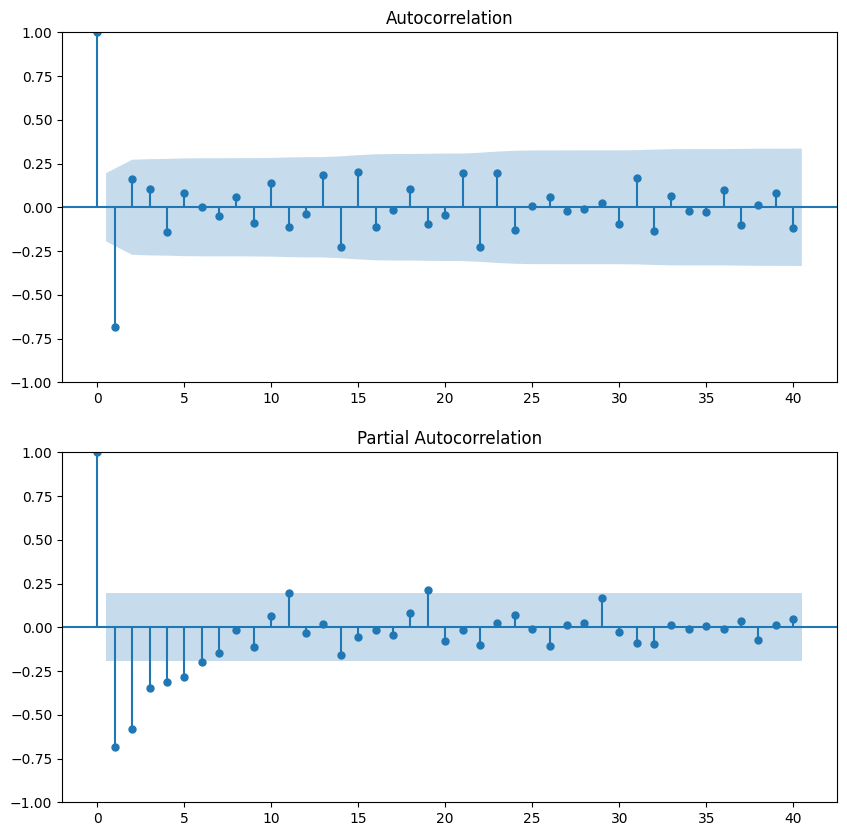

In [56]:
#Plot ACF and PACF
plot_acf_pacf(stationary_vix)

In [59]:
#Suggest p and q
p, q = suggest_p_q(stationary_vix)
print(f'Suggested p: {p}') 
print(f'Suggested q: {q}')

Suggested p: 39
Suggested q: 1


In [60]:
print(f'Suggested ARIMA order: ({p}, {d}, {q})')

Suggested ARIMA order: (39, 3, 1)


In [98]:

arima_model = ARIMA(vix, order=(p,d,q))
arima_results = arima_model.fit()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWar

In [99]:
print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:                  VIX_x   No. Observations:                  104
Model:                ARIMA(39, 3, 1)   Log Likelihood                -278.147
Date:                Wed, 09 Oct 2024   AIC                            638.294
Time:                        14:49:28   BIC                            745.514
Sample:                             0   HQIC                           681.700
                                - 104                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8476      0.858     -2.153      0.031      -3.530      -0.165
ar.L2         -2.6951      2.040     -1.321      0.186      -6.694       1.303
ar.L3         -3.4760      3.365     -1.033      0.3

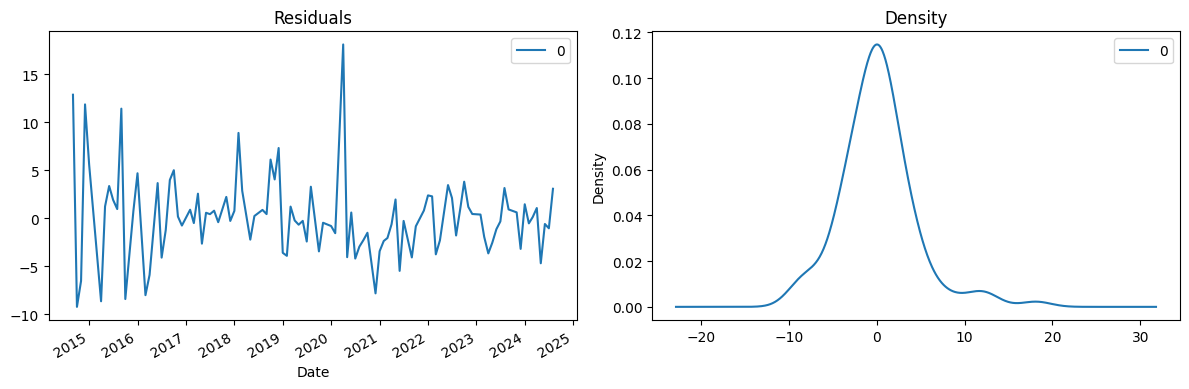

In [100]:
#Plot the residuals to check for any remaining patterns
arima_residuals = pd.DataFrame(arima_results.resid)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
arima_residuals.plot(title = 'Residuals', ax=ax[0])
arima_residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()
plt.show()

In [101]:
#Use the model to make forecasts
arima_forecast = arima_results.forecast(steps=30) #Forecase next 30 periods
print(arima_forecast)
arima_forecast = pd.DataFrame(arima_forecast, columns=['ARIMA Forecast'])

104    14.323214
105    11.952412
106    12.000325
107    10.264969
108     9.498709
109     7.718264
110     6.047176
111     1.648922
112     0.559316
113     0.036035
114     0.032501
115    -3.220844
116    -5.044141
117    -5.693034
118    -4.203883
119    -5.827180
120    -6.318435
121    -6.812789
122    -7.193046
123    -7.219793
124    -7.060289
125    -8.266171
126    -9.447582
127   -10.673901
128   -12.512149
129   -13.410691
130   -14.819687
131   -18.005355
132   -21.992187
133   -23.129058
Name: predicted_mean, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


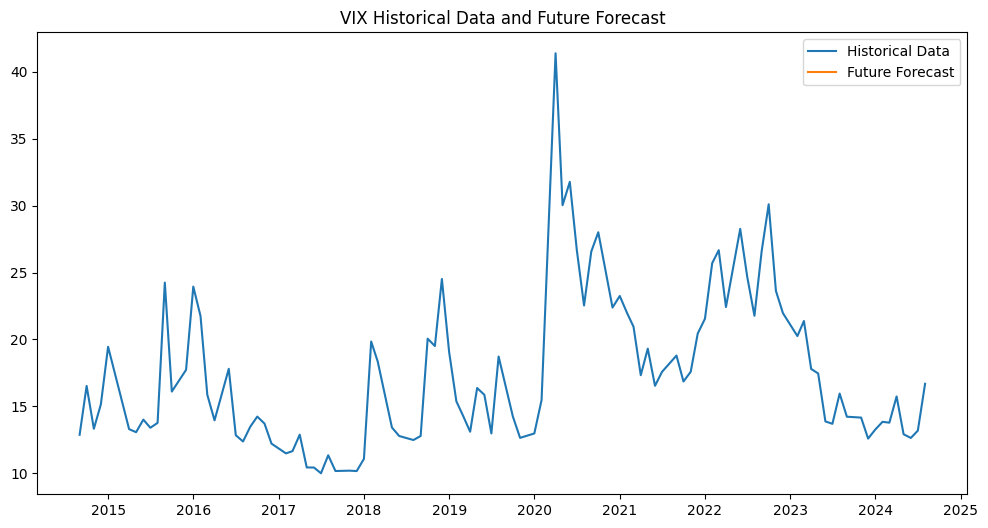

In [89]:
#Plot the entire series with future forecast
plt.figure(figsize=(12,6))
plt.plot(vix, label='Historical Data')
plt.plot(arima_forecast, label='Future Forecast')
plt.title('VIX Historical Data and Future Forecast')
plt.legend()
plt.show()

In [90]:
#Calculate and print AIC and BIC
print(f'AIC: {arima_results.aic}')
print(f'BIC: {arima_results.bic}')

AIC: 719.1378598431423
BIC: 825.1215264686358


In [91]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [95]:
#In-sample prediction adn RMSE
in_sample_pred = arima_results.get_prediction(start=stationary_vix.index[0], end=stationary_vix.index[-1])
in_sample_mean = in_sample_pred.predicted_mean
rmse = sqrt(mean_squared_error(stationary_vix, in_sample_mean))
print(f'In-sample RMSE: {rmse}')

In-sample RMSE: 10.597807461169065


Incorporating Other Features
Using SARIMAX

In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [84]:
print(data.head())

            Unemployment Rate      CPI  Three Month T Bill Rate  \
Date                                                              
2014-09-01                5.9  237.477                     0.02   
2014-10-01                5.7  237.430                     0.02   
2014-11-01                5.8  236.983                     0.02   
2014-12-01                5.6  236.252                     0.03   
2015-01-01                5.7  234.747                     0.03   

            Six Month T Bill Rate  10-Year Treasury Constant Maturity Rate  \
Date                                                                         
2014-09-01                   0.04                                     2.53   
2014-10-01                   0.05                                     2.30   
2014-11-01                   0.07                                     2.33   
2014-12-01                   0.11                                     2.21   
2015-01-01                   0.08                             

In [85]:
#Features are other columns from the same data file
exog_data = data[['Unemployment Rate','CPI','Three Month T Bill Rate','Six Month T Bill Rate','10-Year Treasury Constant Maturity Rate','Fed Rate','BBB Rate','SP500 Index','GDP']]

In [86]:
#SARIMAX
sarimax_model = SARIMAX(data['VIX_x'], exog_data, order=(p,d,q))
sarimax_results = sarimax_model.fit()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarni

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           50     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12284D+00    |proj g|=  3.77701D+00

At iterate    5    f=  4.01737D+00    |proj g|=  1.47462D+02

At iterate   10    f=  3.22402D+00    |proj g|=  1.02340D+00

At iterate   15    f=  3.19386D+00    |proj g|=  4.34224D+01

At iterate   20    f=  2.79969D+00    |proj g|=  5.24382D+01

At iterate   25    f=  2.69745D+00    |proj g|=  9.88177D+00

At iterate   30    f=  2.67291D+00    |proj g|=  8.45562D+00

At iterate   35    f=  2.58459D+00    |proj g|=  5.81077D+00

At iterate   40    f=  2.58027D+00    |proj g|=  2.46652D+00

At iterate   45    f=  2.54643D+00    |proj g|=  5.18380D+00


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.50959D+00    |proj g|=  8.58602D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   50     50     62      1     0     0   8.586D-01   2.510D+00
  F =   2.5095894436492099     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
